In [ ]:
## Get the stats per discipline/per language of how many papers were published?

In [ ]:
!pip install plotly pandas seaborn kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.3 MB/s eta 0:00:00


## For the Zenodo data

- https://zenodo.org/records/15784401 (GoTriple metadata dataset)

In [1]:
import gzip
import json
import requests
import pandas as pd

def download_jsonl_gz_file(url: str):
  response = requests.get(url, stream=True)

  filename = url.split("?")[0].split("/")[-1]
  with open(f"/content/{filename}", "wb") as f:
      for chunk in response.iter_content(chunk_size=8192):
          f.write(chunk)

# taking 4 categories as example for downloading the data and reading them as a dataframe
domains = ["anthro-se", "anthro-bio", "class", "genre"]
for d in domains:
  url = f"https://zenodo.org/records/15784401/files/{d}_merged.jsonl.gz?download=1"
  download_jsonl_gz_file(url)

In [3]:
domain_df_dict = dict()
for d in domains:
  domain_df_dict[d] = pd.read_json(
      f"/content/{d}_merged.jsonl.gz",
      lines=True,
      compression="gzip",
      chunksize=None,
      dtype=False,
  )

In [13]:
## example of how one row looks like
domain_df_dict["anthro-se"].iloc[0]

,0
@id,/documents/oai:doaj.org/article:1b6ab1b2ec9340...
@type,Document
id,oai:doaj.org/article:1b6ab1b2ec93407abc43de92c...
abstract,"[{'@type': 'CommonTranslatedLabel', '@id': '_:..."
additional_type,[typ_article]
cluster_children_count,NaN
cluster_id,[]
conditions_of_access,[undefined]
contributor,[]
date_published,1974-06-01


In [9]:
for d in domains:
  print(f"For domain: {d}")
  print(f"Columns extracted: {domain_df_dict[d].columns}")
  print(f"Shape of the dataframe: {domain_df_dict[d].shape}\n")

For domain: anthro-se
Columns extracted: Index(['@id', '@type', 'id', 'abstract', 'additional_type',
       'cluster_children_count', 'cluster_id', 'conditions_of_access',
       'contributor', 'date_published', 'date_facets', 'datestamp', 'doi',
       'full_text', 'headline', 'identifier', 'in_language', 'is_cluster',
       'is_duplicate', 'keywords', 'discarded_keywords', 'discarded_authors',
       'knows_about', 'license', 'main_entity_of_page', 'mentions',
       'original_conditions_of_access', 'original_document_types',
       'original_languages', 'original_license', 'producer', 'provider',
       'publisher', 'spatial_coverage', 'temporal_coverage', 'topic', 'url',
       'author'],
      dtype='object')
Shape of the dataframe: (108285, 38)



In [11]:
# for example: get the category anthro-se get the unique languges and their respective count from the DF
def get_language_counts(domain: str):
  selected_metadata = domain_df_dict[domain]
  all_languages = set(selected_metadata["in_language"].explode())
  print(f"Languages present: {all_languages}")
  language_counts = selected_metadata["in_language"].explode().value_counts()
  return language_counts

In [12]:
get_language_counts("anthro-se")

Languages present: {'de', 'sr', 'fi', 'uk', 'other', 'pt', 'tr', 'es', 'nl', 'sq', 'en', 'fr', 'undefined', 'hr', 'it', 'ru', 'hu', 'da', 'ar', 'pl', 'ca', 'sl', 'el', 'no', 'sv', 'he'}


,count
in_language,
en,69373
fr,15206
undefined,13012
pl,10101
es,9762
other,9094
de,7289
sr,7009
pt,4601


## For the API

In [ ]:
# https://api.gotriple.eu/
import requests
import numpy as np
import pandas as pd

url = "https://api.gotriple.eu/documents"

topics = [
    'anthro-bio', 'anthro-se', 'archeo', 'archi', 'art', 'class', 'demo',
    'droit', 'eco', 'edu', 'envir', 'genre', 'geo', 'hisphilso','hist',
    'info', 'lang', 'litt', 'manag', 'museo', 'musiq', 'phil', 'psy',
    'relig', 'scipo', 'socio', 'stat'
]

def get_count_metadata_per_discipline(has_pdf_params: bool = False):
  """Get the count metadata per discipline"""
  count_metadata_per_discipline = dict()

  for t in topics:
    params = {
        "q": "",
        "include_duplicates": "false",
        "fq": f"topic={t}",
        "aggs": "in_language,size=100",
        "sort": "most_recent",
        "page": 1,
        "size": ""
    }
    if has_pdf_params:
      params["fq"] = params["fq"] + ";" + "has_pdf=true"

    headers = {"accept": "application/ld+json"}

    # Make the request to the GoTripleAPI
    response = requests.get(url, params=params, headers=headers)
    total_items = response.json()["hydra:totalItems"]
    language_bucket_counts = response.json()["aggs"]["in_language"]["buckets"]
    count_metadata_per_discipline.setdefault(t, dict())
    count_metadata_per_discipline[t]["total_items"] = total_items
    count_metadata_per_discipline[t]["language_count"] = language_bucket_counts
  return count_metadata_per_discipline

In [ ]:
# to check for year if there is a language-year pair aggregated such that it is greater than 10,000
count_metadata_per_discipline = get_count_metadata_per_discipline()

In [ ]:
# set a language code map for renaming the columns of the dataframe
language_code_map = {
   "ar": "Arabic",
   "it": "Italian",
   "pl": "Polish",
   "hr": "Croatian",
   "el": "Greek",
   "de": "German",
   "sv": "Swedish",
   "ru": "Russian",
   "en": "English",
   "undefined": "Undefined",
   "es": "Spanish",
   "nl": "Dutch",
   "other": "Other",
   "tr": "Turkish",
   "pt": "Portuguese",
   "fr": "French",
   "uk": "Ukrainian",
   "sr": "Serbian",
   "hu": "Hungarian",
   "no": "Norwegian",
   "ca": "Catalan",
   "fi": "Finnish",
   "sq": "Albanian",
   "sl": "Slovenian",
   "he": "Hebrew",
   "da": "Danish"
}

discipline_map = {
    'hist': 'History',
    'socio': 'Sociology',
    'phil': 'Philosophy',
    'lang': 'Linguistics',
    'envir': 'Environmental studies',
    'edu': 'Education',
    'psy': 'Psychology',
    'scipo': 'Political Science',
    'geo': 'Geography',
    'eco': 'Economies and Finances',
    'musiq': 'Musicology and Performing Arts',
    'manag': 'Management',
    'litt': 'Literature',
    'art': 'Art and Art History',
    'droit': 'Law',
    'info': 'Communication Sciences',
    'demo': 'Demography',
    'hisphilso': 'History, Philosophy and Sociology of Sciences',
    'anthro-se': 'Social Anthropology and Ethnology',
    'archi': 'Architecture and Space Management',
    'relig': 'Religions',
    'archeo': 'Archaeology and Prehistory',
    'stat': 'Methods and Statistics',
    'genre': 'Gender Studies',
    'class': 'Classical Studies',
    'museo': 'Cultural Heritage and Museology',
    'anthro-bio': 'Biological Anthropology'
}

def create_language_dataframe(data_dict):
   """Create language dataframe from the counts"""
   records = []

   # Get all unique language keys
   all_languages = set()
   for topic, topic_data in data_dict.items():
       for lang_item in topic_data['language_count']:
           all_languages.add(lang_item['key'])

   # For each topic, create a record
   for topic, topic_data in data_dict.items():
       # Create a dict with topic as index and initialize all language counts to 0
       record = {'topic': topic, 'total_items': topic_data['total_items']}
       record.update({lang: 0 for lang in all_languages})

       # Fill in the actual language counts
       for lang_item in topic_data['language_count']:
           record[lang_item['key']] = lang_item['doc_count']

       records.append(record)

   df = pd.DataFrame(records)
   df = df.set_index('topic')

   renamed_columns = {}
   for col in df.columns:
       if col in language_code_map:
           renamed_columns[col] = language_code_map[col]
   df = df.rename(columns=renamed_columns)

   new_index = [discipline_map.get(idx, idx) for idx in df.index]
   df.index = new_index

   return df

In [ ]:
count_metadata_per_discipline = get_count_metadata_per_discipline()
discpline_language_dataframe = create_language_dataframe(count_metadata_per_discipline)

# with full text pdf as an additional filter
count_metadata_per_discipline_with_pdf = get_count_metadata_per_discipline(has_pdf_params=True)
discpline_language_dataframe_with_pdf = create_language_dataframe(count_metadata_per_discipline_with_pdf)

In [ ]:
discpline_language_dataframe

,total_items,Italian,Catalan,French,Finnish,Albanian,Croatian,Arabic,Undefined,Ukrainian,...,Serbian,Russian,Spanish,Polish,German,Other,English,Slovenian,Norwegian,Dutch
Biological Anthropology,65016,113,2,2711,3,1,16,21,3965,35,...,16,129,144,323,16573,566,41652,35,28,26
Social Anthropology and Ethnology,697219,12493,2627,149310,1272,124,6000,1388,119374,1971,...,5219,7156,113576,16733,12799,26722,292392,3032,1388,1376
Archaeology and Prehistory,501818,8980,1385,105676,405,47,3066,963,97984,1029,...,896,8348,42165,14758,21932,13314,202097,1848,644,17885
Architecture and Space Management,694483,14054,1018,74143,3889,52,4196,3760,138262,2331,...,1197,5679,46840,8224,19519,29011,379104,1837,1315,5099
Art and Art History,1144851,22290,3534,229704,4249,118,7854,5724,311478,4950,...,1960,13885,81045,27992,30966,46553,431511,3803,2708,3536
Classical Studies,189223,6362,646,68396,579,14,2257,817,28313,193,...,368,1842,18236,3757,9922,10489,52217,1372,384,967
Demography,975758,4013,416,40435,4474,62,3376,1206,153101,5662,...,1509,22082,22467,10634,11764,30866,698444,2801,737,1576
Law,1121010,16480,2008,133154,2185,63,13733,5031,232783,14533,...,5072,35572,89839,34630,38378,64576,502861,3532,1102,4052
Economies and Finances,1563471,5388,569,81107,4470,72,7277,4128,191413,17348,...,2917,39007,98179,30994,26722,95185,1019758,2193,860,1814
Education,2086371,13746,2307,98448,8127,147,11584,12004,322663,18677,...,2837,32007,194221,22770,92166,157053,1204113,4072,6273,1396


In [ ]:
discpline_language_dataframe_with_pdf

,total_items,Italian,Catalan,French,Finnish,Albanian,Croatian,Arabic,Undefined,Ukrainian,...,Serbian,Russian,Spanish,Polish,German,Other,English,Slovenian,Norwegian,Dutch
Biological Anthropology,8886,33,1,272,1,0,6,18,484,2,...,11,24,17,144,4660,158,3572,9,0,5
Social Anthropology and Ethnology,101650,1115,94,16077,56,15,530,194,13431,110,...,2972,1176,4621,8005,3497,4953,54794,246,22,113
Archaeology and Prehistory,65631,784,9,9339,27,0,180,362,5164,80,...,543,1270,2005,9586,5118,3086,35187,160,10,76
Architecture and Space Management,119980,1049,8,20384,131,5,193,752,13876,107,...,957,811,2103,4759,6572,6724,78300,359,3,143
Art and Art History,146557,1667,43,18144,101,5,604,1082,24031,286,...,1188,2666,3665,14911,7818,9237,76150,228,31,335
Classical Studies,20312,560,6,3985,2,0,106,208,1486,14,...,205,371,514,2357,3205,1318,8324,35,6,45
Demography,165491,491,10,11882,140,4,179,268,20072,655,...,1061,2605,1289,6892,3400,7116,123589,557,29,160
Law,191494,1746,210,15696,33,1,515,1292,29920,466,...,3466,2485,4083,19048,9027,15028,103526,207,12,1076
Economies and Finances,307055,1630,24,21992,121,3,243,717,30620,3719,...,2122,6106,3382,21845,9473,21339,215804,201,14,372
Education,319954,710,40,18252,79,7,592,2118,53969,955,...,1846,2554,8359,10989,32216,24778,185575,447,46,298


In [ ]:
set(list(discpline_language_dataframe_with_pdf.columns)) - set(list(discpline_language_dataframe.columns))

set()

In [ ]:
print(f"""
  Papers with undefined language: {discpline_language_dataframe["Undefined"].sum()}
  with others language: {discpline_language_dataframe["Other"].sum()}
  """
)
print(f"""
  Total papers: {discpline_language_dataframe["total_items"].sum()}
  Total papers with full text: {discpline_language_dataframe_with_pdf["total_items"].sum()}
  """
)


  Papers with undefined language: 6313878
  with others language: 1718819
  

  Total papers: 35541869
  Total papers with full text: 5774910
  


In [ ]:
# save the dataframes
discpline_language_dataframe.to_csv("discipline_language_count_df.csv")
discpline_language_dataframe_with_pdf.to_csv("discpline_language_dataframe_with_pdf.csv")

In [ ]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

def create_language_distribution_plot(df):
    """Create for each language the countplot discipline plot"""
    lang_cols = [col for col in df.columns if col != 'total_items']

    df_melted = pd.melt(
        df.reset_index(),
        id_vars=['index'],
        value_vars=lang_cols,
        var_name='Language',
        value_name='Count'
    )

    # Filter out zeros to focus on existing language counts
    df_melted = df_melted[df_melted['Count'] > 0]

    # Get top 5 disciplines for each language
    top_disciplines = {}
    for language in df_melted['Language'].unique():
        language_data = df_melted[df_melted['Language'] == language].sort_values('Count', ascending=False)
        top_disciplines[language] = language_data.head(5)

    plt.figure(figsize=(16, 20))

    num_languages = min(9, len(top_disciplines))
    languages_to_plot = sorted(top_disciplines.keys(),
                              key=lambda x: df_melted[df_melted['Language'] == x]['Count'].sum(),
                              reverse=True)[:num_languages]


    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    for i, language in enumerate(languages_to_plot):
        if i < len(axes):
            ax = axes[i]
            data = top_disciplines[language]

            data = data.sort_values('Count')
            sns.barplot(x='Count', y='index', data=data, ax=ax, palette='viridis')
            ax.set_title(f'Top 5 Disciplines for {language}', fontsize=12)
            ax.set_xlabel('Number of Documents', fontsize=10)
            ax.set_ylabel('Discipline', fontsize=10)

            # Add count values on bars
            for j, v in enumerate(data['Count']):
                ax.text(v + 0.1 * max(data['Count']), j, f"{v:,}",
                       va='center', fontsize=9)

    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.suptitle('Top 5 Disciplines by Language', fontsize=16, y=1.02)

    return plt

<ipython-input-27-2dfdc85ff4ce>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='index', data=data, ax=ax, palette='viridis')
<ipython-input-27-2dfdc85ff4ce>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='index', data=data, ax=ax, palette='viridis')
<ipython-input-27-2dfdc85ff4ce>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='index', data=data, ax=ax, palette='viridis')
<ipython-input-27-2dfdc85ff4ce>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

<Figure size 1600x2000 with 0 Axes>

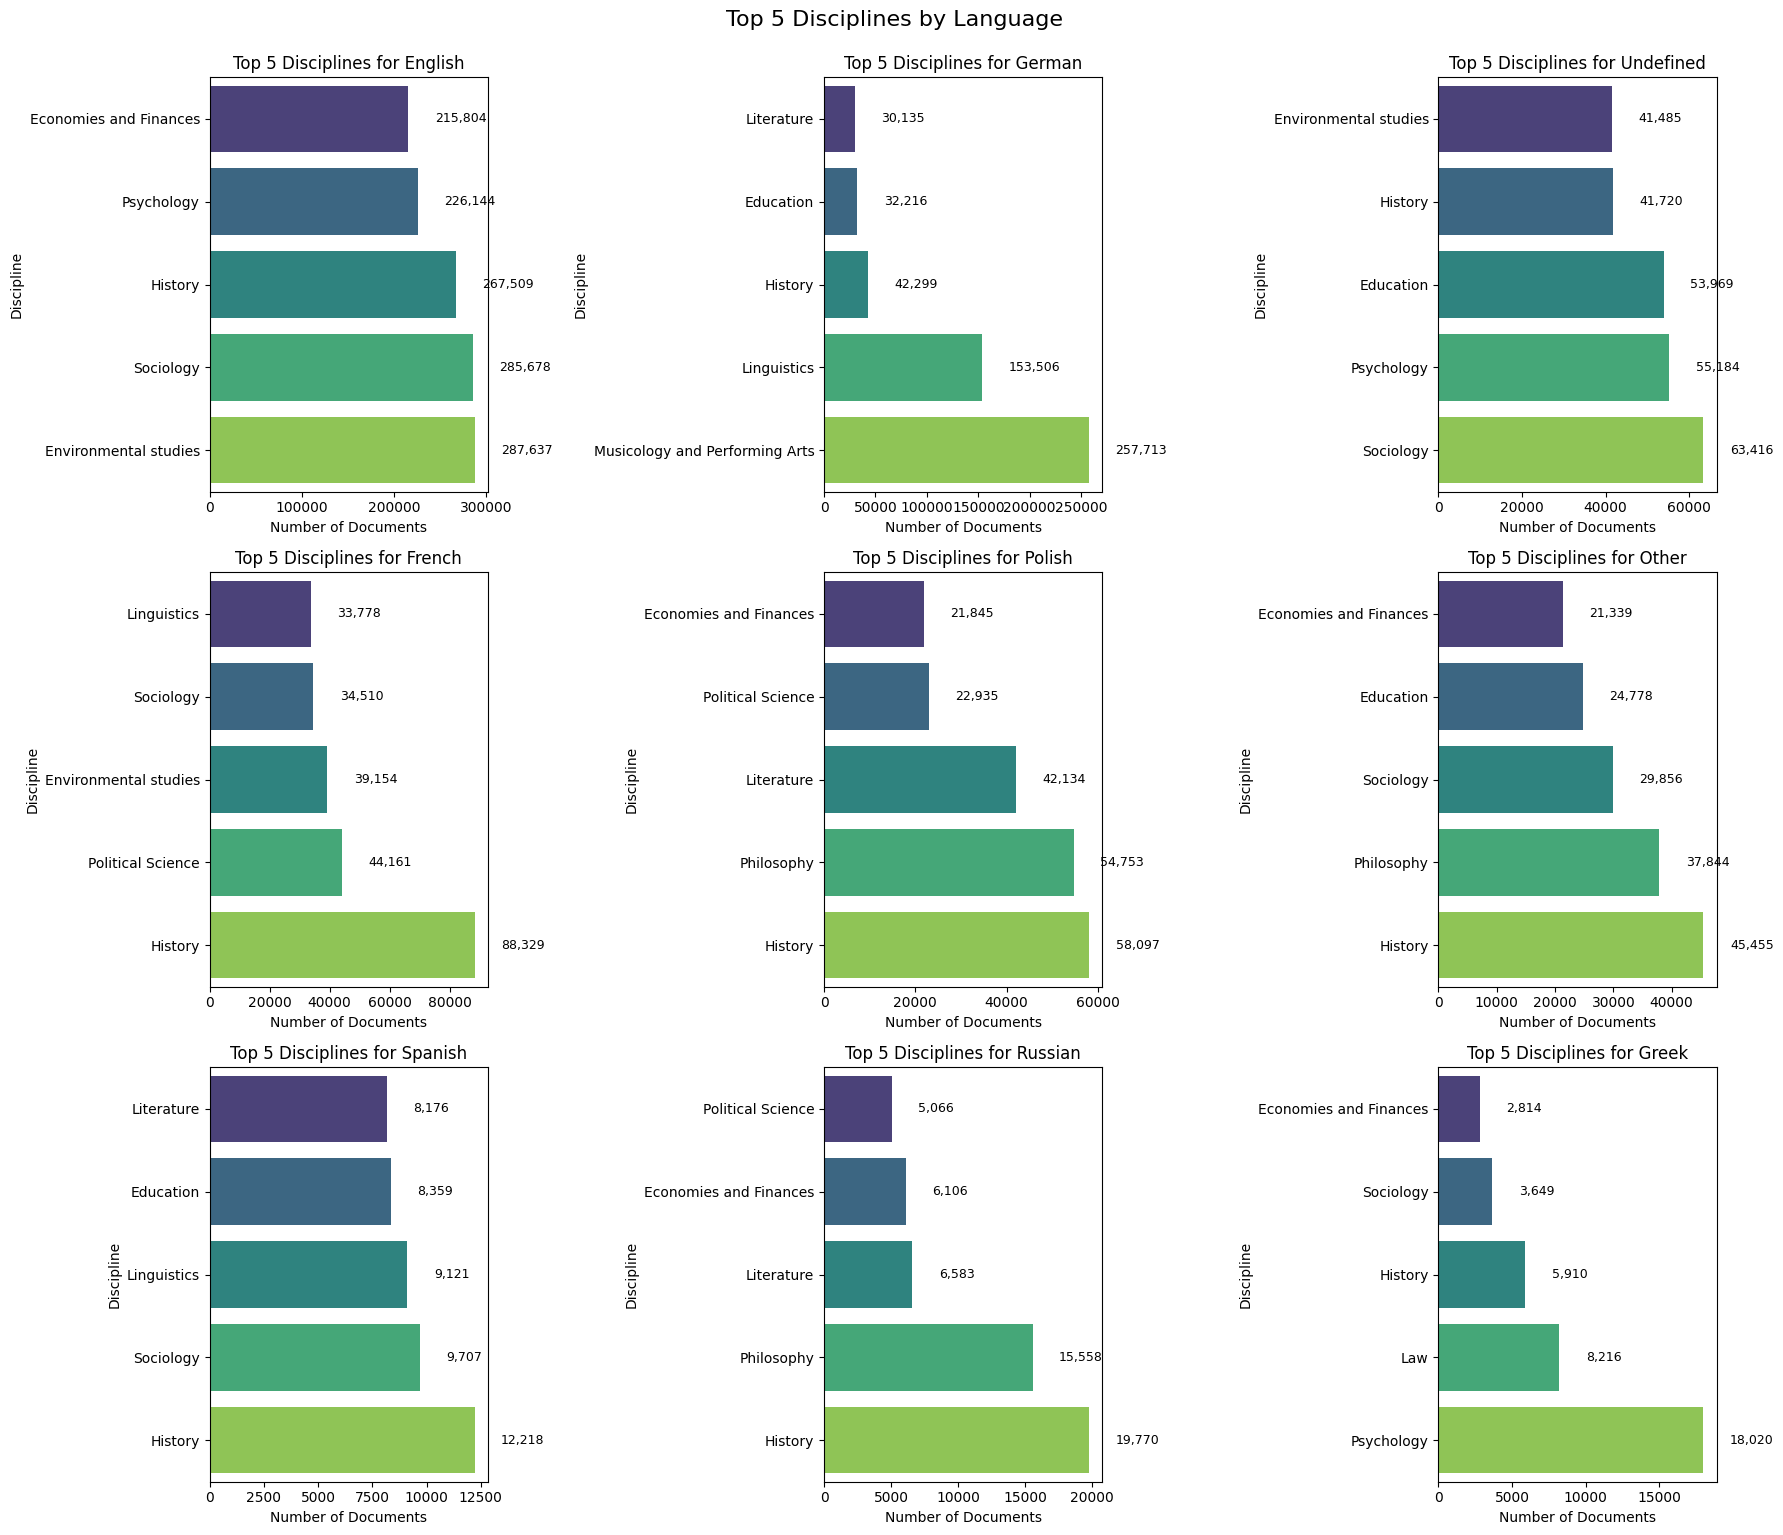

In [ ]:
img = create_language_distribution_plot(discpline_language_dataframe_with_pdf)
# img.savefig('language_distribution_by_discipline.png', dpi=300, bbox_inches='tight')

In [ ]:
def plotly_stacked_bar_chart(df, plot_title: str="Language Counts by Topic"):
    """
    Create a stacked bar chart using Plotly Express.

    Parameters:
    df (DataFrame): DataFrame with topics as index and languages as columns.

    Returns:
    fig: Plotly figure object.
    """
    df = df.copy().drop(columns=['total_items'], errors='ignore')
    df = df.reset_index().rename(columns={'index': 'Topic'})
    language_cols = [col for col in df.columns if col != 'Topic']

    fig = px.bar(
        df,
        x='Topic',
        y=language_cols,       # supply a list of columns; each becomes a trace
        title='Topic Language Counts',
        barmode='stack'        # this makes the bars appear as stacked
    )
    # Optional: update the layout for aesthetics
    fig.update_layout(
        title_text=plot_title,
        height=1000,
        xaxis_title="Topic",
        yaxis_title="Count",
        legend_title="Language",
        template="plotly_white",
        xaxis_tickangle=-45  # Rotate x-axis labels for better readability
    )
    image_title = plot_title.lower().replace(" ", "_")
    fig.write_image(f"{image_title}.png")
    fig.show()

In [ ]:
plotly_stacked_bar_chart(discpline_language_dataframe)

In [ ]:
plotly_stacked_bar_chart(
    discpline_language_dataframe_with_pdf, plot_title="Language counts by Topic (with pdf)")